In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [107]:
%ls

loss_5000  mona-lisa-small  Untitled.ipynb


900 604 3
543600 3


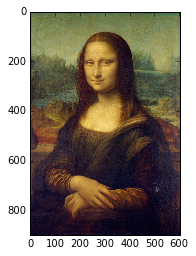

In [14]:
pic = plt.imread('mona-lisa-small')
plt.imshow(pic)
hei, wid, chl = pic.shape
ground_truth = pic.reshape(-1, chl)
leng, _ = ground_truth.shape
print hei, wid, chl
print leng, _

In [44]:
idx = np.arange(leng)
x = np.array([i / wid for i in idx])
y = np.array([i % wid for i in idx])
xy = np.column_stack((x, y))

# sample shape: 5000 * 5 (x, y, r, g, b)
sample_size = 5000
sample_idx = np.random.choice(np.arange(leng), size=sample_size)
sample = ground_truth[sample_idx, :].astype(np.float) / 255
train = np.column_stack((xy[sample_idx, :], sample))

print train.shape

# assertion
_ = np.random.randint(0, sample_size)
np.allclose(pic[int(train[_,0]), int(train[_,1]), :] / 255.0, train[_, 2:])  

# build data set
x_train = train[:, :2]
y_train = train[:, 2:]
x_test = xy
y_test = ground_truth / 255.0

(5000, 5)


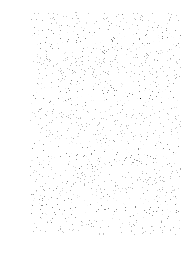

In [30]:
_sample_indicator = np.ones((leng ,1))
_sample_indicator[sample_idx] = 0
_sample_indicator = _sample_indicator.reshape(hei, wid)
plt.imshow(_sample_indicator, cmap='gray')
plt.axis('off')
plt.show()

## Random Forest Approximation

In [19]:
from sklearn.ensemble import RandomForestRegressor as RF

In [27]:
rf_r = RF()
rf_r.fit(train[:, :2], train[:, 2])
rf_g = RF()
rf_g.fit(train[:, :2], train[:, 3])
rf_b = RF()
rf_b.fit(train[:, :2], train[:, 4])


rf = RF()
rf.fit(train[:, :2], train[:, 2:])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

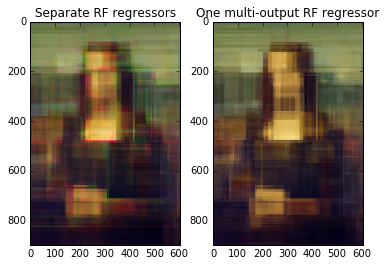

In [28]:
plt.subplot(1,2,1)
pred_pic = np.column_stack((rf_r.predict(xy), rf_g.predict(xy), rf_b.predict(xy))).reshape(hei, wid, chl)
assert pred_pic.shape == (hei, wid, chl)
plt.imshow(pred_pic)
plt.title('Separate RF regressors')

plt.subplot(1,2,2)
pred_pic = rf.predict(xy).reshape(hei, wid, chl)
plt.imshow(pred_pic)
plt.title('One multi-output RF regressor')

### Experiment

#### Single decision tree, different depths

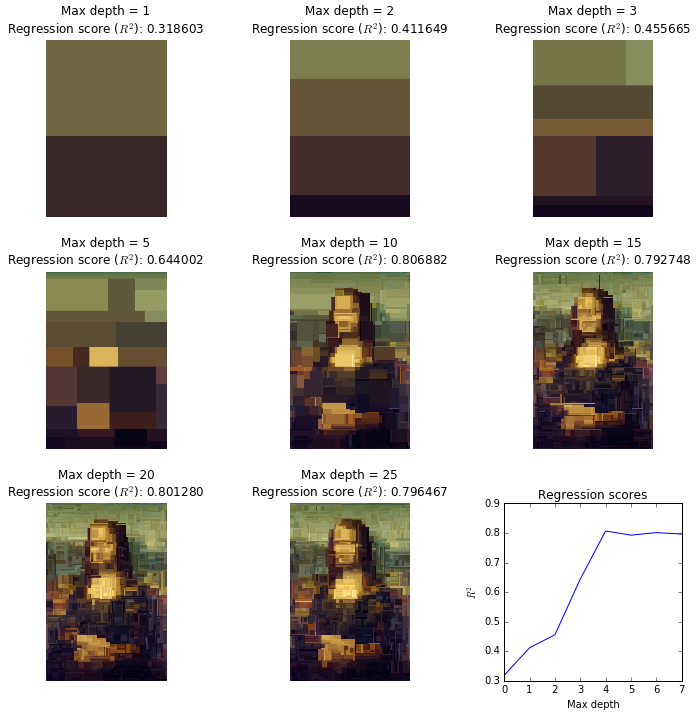

In [31]:
r2_scores = []
depth = [1,2,3,5,10,15, 20, 25]
ROW_PLT = 3
COL_PLT = 3
plt.figure(figsize=[10, 10])
for i, d in enumerate(depth):
    reg = RF(n_estimators=1, max_depth=d)
    reg.fit(x_train, y_train)
    
    _pred_pic = reg.predict(x_test).reshape(hei, wid, chl)
    plt.subplot(ROW_PLT, COL_PLT, i + 1)
    plt.imshow(_pred_pic)
    plt.axis('off')
    r2 = reg.score(x_test, y_test)
    r2_scores.append(r2)
    plt.title('Max depth = %d\nRegression score ($R^2$): %f' % (d, r2))
plt.subplot(ROW_PLT, COL_PLT, ROW_PLT*COL_PLT)
plt.plot(r2_scores)
plt.title('Regression scores')
plt.ylabel('$R^2$')
plt.xlabel('Max depth')
plt.tight_layout()

#### Fixed depth, different number of decision trees

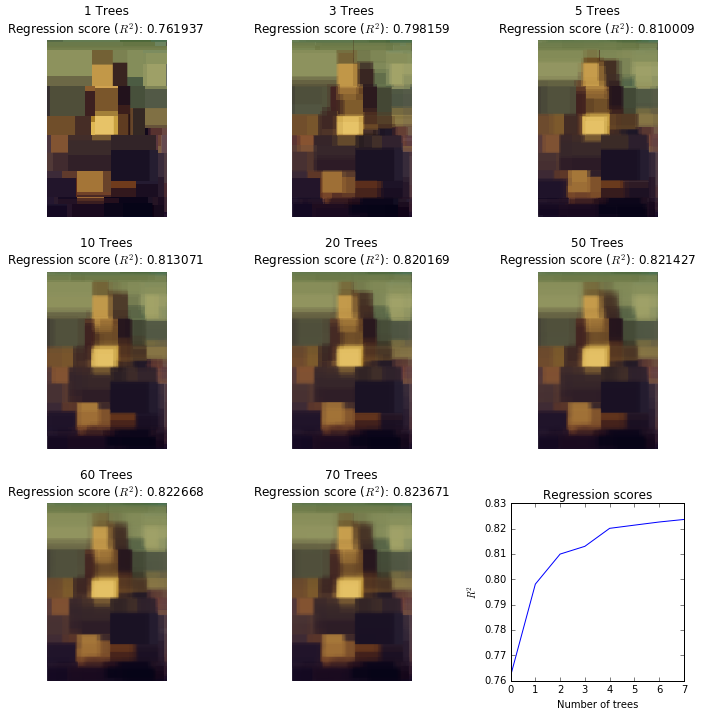

In [96]:
# n_trees = [1,3,5,10,100,200]
ROW_PLT = 3
COL_PLT = 3
r2_scores = []
n_trees = [1,3,5,10,20,50, 60, 70]
plt.figure(figsize=[10, 10])
for i, n in enumerate(n_trees):
    reg = RF(n_estimators=n, max_depth=7)
    reg.fit(x_train, y_train)
    
    _pred_pic = reg.predict(x_test).reshape(hei, wid, chl)
    plt.subplot(ROW_PLT, COL_PLT, i + 1)
    plt.imshow(_pred_pic)
    plt.axis('off')
    r2 = reg.score(x_test, y_test)
    r2_scores.append(r2)
    plt.title('%d Trees\nRegression score ($R^2$): %f' % (n, r2))
    
plt.subplot(ROW_PLT, COL_PLT, ROW_PLT*COL_PLT)
plt.plot(r2_scores)
plt.title('Regression scores')
plt.ylabel('$R^2$')
plt.xlabel('Number of trees')
plt.tight_layout()

#### 1-NN baseline

In [33]:
from sklearn.neighbors import KNeighborsRegressor as kNN

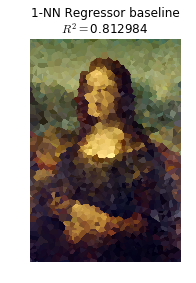

0.81298448599052797

In [43]:
knn = kNN(n_neighbors=1)
knn.fit(x_train, y_train)
_pred_pic = knn.predict(x_test).reshape(hei, wid, chl)
sc = knn.score(x_test, y_test)
plt.imshow(_pred_pic)
plt.axis('off')
plt.title('1-NN Regressor baseline\n$R^2=$%f' % sc)
plt.show()
knn.score(x_test, y_test)

#### Pruning

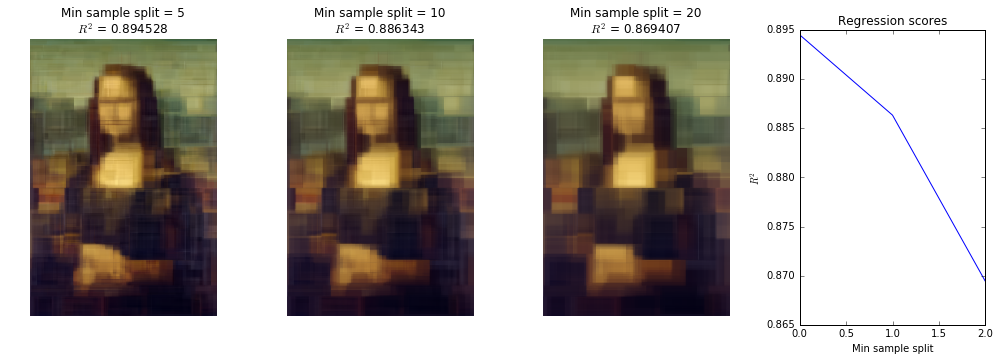

In [46]:
n_trees = 50
max_depth = 20

split_list = [5, 10, 20]

ROW_PLT = 1
COL_PLT = 4
r2_scores = []
plt.figure(figsize=[14, 5])
for i, split in enumerate(split_list):
    reg = RF(n_estimators=n_trees, max_depth=max_depth, min_samples_split=split)
    reg.fit(x_train, y_train)
    _pred_pic = reg.predict(x_test).reshape(hei, wid, chl)
    plt.subplot(ROW_PLT, COL_PLT, i+1)
    plt.imshow(_pred_pic)
    plt.axis('off')
    sc = reg.score(x_test, y_test)
    r2_scores.append(sc)
    plt.title('Min sample split = %d\n$R^2$ = %f' % (split, sc))
    
plt.subplot(ROW_PLT, COL_PLT, COL_PLT)
plt.plot(r2_scores)
plt.title('Regression scores')
plt.ylabel('$R^2$')
plt.xlabel('Min sample split')
plt.tight_layout()

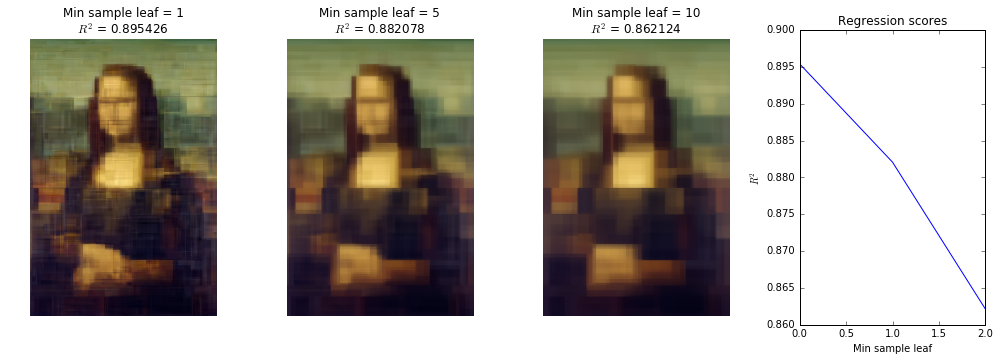

In [48]:
n_trees = 50
max_depth = 20

leaf_list = [1, 5, 10]

ROW_PLT = 1
COL_PLT = 4
r2_scores = []
plt.figure(figsize=[14, 5])
for i, leaf in enumerate(leaf_list):
    reg = RF(n_estimators=n_trees, max_depth=max_depth, min_samples_leaf=leaf)
    reg.fit(x_train, y_train)
    _pred_pic = reg.predict(x_test).reshape(hei, wid, chl)
    plt.subplot(ROW_PLT, COL_PLT, i+1)
    plt.imshow(_pred_pic)
    plt.axis('off')
    sc = reg.score(x_test, y_test)
    r2_scores.append(sc)
    plt.title('Min sample leaf = %d\n$R^2$ = %f' % (leaf, sc))
    
plt.subplot(ROW_PLT, COL_PLT, COL_PLT)
plt.plot(r2_scores)
plt.title('Regression scores')
plt.ylabel('$R^2$')
plt.xlabel('Min sample leaf')
plt.tight_layout()

## ConvNetJS Loss

In [164]:
loss = np.loadtxt('loss_5000')
loss_ori = np.loadtxt('loss_5000_original')
loss_change_lr = np.loadtxt('loss_5000_changeLR')
print loss

[ 0.1094076   0.07980946  0.05695627  0.04168624  0.03172467  0.02519257
  0.02086333  0.01801145  0.01610265  0.01453296  0.01399025  0.01323752
  0.01232349  0.01183375  0.01174903  0.01130039  0.01104297  0.01062111
  0.01040268  0.01006757  0.00981742  0.00975506  0.00944977  0.00937751
  0.00924267  0.0091523   0.00897567  0.00891119  0.00886002  0.00872606
  0.00851149  0.00855046  0.00831221  0.00839669  0.00829314  0.00808916
  0.00794915  0.00785731  0.00766639  0.00765282  0.00754119  0.00740942
  0.0071975   0.00739672  0.00721709  0.00712893  0.00725331  0.00726303
  0.00716447  0.00724398  0.00717867  0.00695561  0.0069172   0.0068023
  0.0069487   0.00703792  0.0069437   0.00684205  0.00671404  0.00653788
  0.00661074  0.00670204  0.00661101  0.00651793  0.00634556  0.00629999
  0.00640241  0.00646482  0.00632246  0.00629176  0.00628299  0.00610835
  0.00611765  0.00608362  0.00607761  0.00605966  0.00596425  0.00624281
  0.00613185  0.00626564  0.00618344  0.00605054  0.

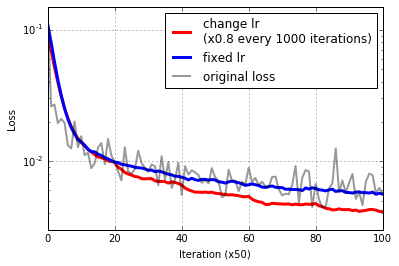

In [169]:
plt.semilogy(loss_change_lr, linewidth=3, color='r', label='change lr \n(x0.8 every 1000 iterations)')
plt.semilogy(loss, linewidth=3, label='fixed lr')
plt.semilogy(loss_ori, linewidth=2, color='k', alpha=0.4, label='original loss')
plt.ylabel('Loss')
plt.xlabel('Iteration (x50)')
plt.ylim((3e-3, 1.5e-1))
plt.legend()
plt.grid()

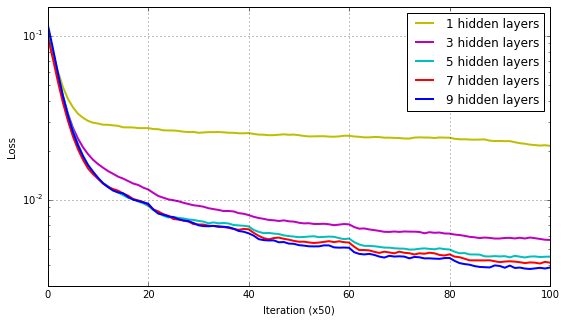

In [13]:
colors = list('ymcrb')
plt.figure(figsize=[9,5])
for i in range(1, 10, 2):
    c = colors[i / 2]
    d = np.loadtxt('loss/loss_hidden_%d' % i)
    plt.semilogy(d, linewidth=2, color=c, label='%d hidden layers' % i)
plt.ylabel('Loss')
plt.xlabel('Iteration (x50)')
plt.ylim((3e-3, 1.5e-1))
plt.legend()
plt.grid()
plt.show()

In [12]:
%whos

Variable   Type                     Data/Info
---------------------------------------------
RF         ABCMeta                  <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
chl        int                      3
f_pic      ndarray                  543600x3: 1630800 elems, type `uint8`, 1630800 bytes (1 Mb)
hei        int                      900
i          int64                    543599
idx        ndarray                  543600: 543600 elems, type `int64`, 4348800 bytes (4 Mb)
leng       int                      543600
np         module                   <module 'numpy' from '/ho<...>ages/numpy/__init__.pyc'>
pic        ndarray                  900x604x3: 1630800 elems, type `uint8`, 1630800 bytes (1 Mb)
plt        module                   <module 'matplotlib.pyplo<...>s/matplotlib/pyplot.pyc'>
pred_pic   ndarray                  900x604x3: 1630800 elems, type `float64`, 13046400 bytes (12 Mb)
rf_b       RandomForestRegressor    RandomForestRegressor(boo<...>bose=0, warm_st